# Simple tutorial for understanding uncertainty part

* This notebook file is not intended to execute. Please run the python files (active_DATE.py or further version) instead of running the blocks in this notebook.

## 1. active_DATE.py

In active_DATE.py, there is a parameter for the uncertainty principle : --uncertainty naive or --uncertainty self-supervised.

In [ ]:
parser.add_argument('--uncertainty', type=str, default = 'naive', choices = ['naive', 'self-supervised'], help = 'Uncertainty principle : ambiguity of illicitness or self-supervised manner prediction')

### 1.1 Naive uncertainty principle : ambiguity of illicitness (--uncertainty naive)

In each sampling strategies with needs of uncertainty score, the function get_uncertainty() will do this :

In [ ]:
def get_uncertainty(self):
    if self.uncertainty_module is None :
#         return np.asarray(self.get_output().apply(lambda x : -1.8*abs(x-0.5) + 1)) : This line is deprecated.
        return np.asarray(-1.8*abs(self.get_output()-0.5) + 1) # This line will be worked
#     uncertainty = self.uncertainty_module.measure(self.uncertainty_module.test_data ,'feature_importance')
#     return np.asarray(uncertainty)[self.available_indices] :These two lines are for self-supervised uncertainty.

From self.get_output(), we bring the illicitness probability from the DATE model. Then appling below function, we determine the uncertainty score between 0.1 to 1.

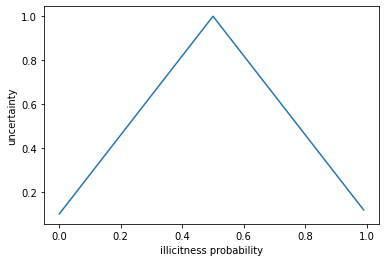

In [1]:
import matplotlib.pyplot as plt
import numpy as np

r = np.arange(0, 1, 0.01)
x = [a for a in r]
y = [-1.8*abs(b-0.5) + 1 for b in r]
plt.plot(x, y)
plt.xlabel('illicitness probability')
plt.ylabel('uncertainty')
plt.show()

This is reasonable because the illicitness probability that is close to 0.5 is ambiguous to determine illicit or not from our model's point of view. Otherwise, if the illicitness probability is in both ends, then the illicitness is confidently illicit, or not.

### 1.2 Self-supervised uncertainty principle : prediction of features with risky profiling (--uncertainty self-supervised)

#### 1.2.1. Initialize the uncertainty module

In active_DATE.py, the uncertainty module will be generated if the sampling startegy needs. With training data, the uncertainty module will train each masked-feature predicitors.

In [ ]:
if unc_mode == 'self-supervised' :
    if samp in ['badge_DATE', 'diversity', 'hybrid']:
        if uncertainty_module is None :
            uncertainty_module = uncertainty.Uncertainty(train_labeled_data, './uncertainty_models/')
            uncertainty_module.train()
        uncertainty_module.test_data = test_data

In [ ]:
class Uncertainty :

    # Features to use : If we use the real data, please fit the feature names properly.
    numerical_features = ['fob.value', 'cif.value', 'total.taxes', 'gross.weight', 'quantity', 'Unitprice', 'WUnitprice', 'TaxRatio', 'FOBCIFRatio', 'TaxUnitquantity']
    categorical_features = ['RiskH.importer.id', 'RiskH.declarant.id',
        'RiskH.HS6.Origin', 'RiskH.tariff.code', 'RiskH.HS6',
        'RiskH.HS4', 'RiskH.HS2', 'RiskH.office.id']
    column_to_use_unc_measure = numerical_features + categorical_features

    def __init__(self, labeled_data, path = './uncertainty_models/') :
        self.classifiers = dict()
        self.regressors = dict()
        self.data = pd.DataFrame(labeled_data)
        self.importance_classifier = None
        self.test_data = None
        self.path = path

In [ ]:
# Initial training with training data

def train(self) :
    for cc in self.categorical_features :
        print('Train for '+cc)
        columns = [col for col in self.column_to_use_unc_measure if col != cc]
        train_set = pd.DataFrame(self.data, columns = columns)
        xgb_clf = XGBClassifier(n_jobs=-1)
        xgb_clf.fit(train_set ,self.data[cc].values)
        self.classifiers[cc] = xgb_clf
        xgb_clf.save_model(self.path + cc + '.model')

    for nc in self.numerical_features :
        print('Train for '+nc)
        columns = [col for col in self.column_to_use_unc_measure if col != nc]
        train_set = pd.DataFrame(self.data, columns = columns)
        xgb_reg = XGBRegressor(n_jobs=-1)
        xgb_reg.fit(train_set, self.data[nc].values)
        self.regressors[nc] = xgb_reg
        xgb_reg.save_model(self.path + nc + '.model')

    self.importance_classifier = XGBClassifier(n_jobs=-1)
    self.importance_classifier.fit(pd.DataFrame(self.data, columns=self.column_to_use_unc_measure), pd.DataFrame(self.data, columns=['illicit']).values.ravel())
    self.importance_classifier.save_model(self.path + 'imp' + '.model')

#### 1.2.2. Uncertainty measurement

For sampling strategies which need the uncertainty measurement, uncertainty score will be given by get_uncertainty function. The uncertainty score from here is applied in the query function of those sampling strategies.

In [ ]:
def get_uncertainty(self):
    if self.uncertainty_module is None :
#         return np.asarray(self.get_output().apply(lambda x : -1.8*abs(x-0.5) + 1)) : This line is deprecated.
#         return np.asarray(-1.8*abs(self.get_output()-0.5) + 1) : This line is for naive uncertainty.
    uncertainty = self.uncertainty_module.measure(self.uncertainty_module.test_data ,'feature_importance')
    return np.asarray(uncertainty)[self.available_indices]

In [ ]:
# Measure the uncertainty of given test data from uncertainty module
def measure(self, test_data, option) :
    print('Uncertainty measure')
    unc = pd.DataFrame()

    for cc in self.categorical_features :
        print('Uncertainty measure : '+cc)
        columns = [col for col in self.column_to_use_unc_measure if col != cc]
        test_set = pd.DataFrame(test_data, columns = columns)
        xgb_clf_pred = self.classifiers[cc].predict(test_set)
        unc['unc.'+cc] = np.bitwise_xor(test_data[cc], xgb_clf_pred.tolist())
        unc['unc.'+cc] = unc['unc.'+cc].apply(lambda x : 0.9*x + 0.1)

        for idx, cat in enumerate(test_data[cc[6:]]) :
            if cat not in set(self.data[cc[6:]]) :
                unc['unc.'+cc][idx] = 1

    for nc in self.numerical_features :
        print('Uncertainty measure : '+nc)
        columns = [col for col in self.column_to_use_unc_measure if col != nc]
        test_set = pd.DataFrame(test_data, columns = columns)
        xgb_reg_pred = self.regressors[nc].predict(test_set)
        unc['unc.'+nc] = abs(test_data[nc] - xgb_reg_pred.tolist()) / test_data[nc]
        unc['unc.'+nc] = np.clip(np.asarray(unc['unc.'+nc]), 0, 1)
        unc['unc.'+nc] = unc['unc.'+nc].apply(lambda x : 0.9*x + 0.1)

    if option == 'naive' :
        # Model 1 : Naive equally-contributing uncertainty (mean)
        return unc.mean(axis=1)

    elif option == 'feature_importance' :
        # Model 2 : Feature importance from illicitness
        return unc.dot(self.importance_classifier.feature_importances_ / sum(self.importance_classifier.feature_importances_))

#### 1.2.3. Retrain after query the samples

After our sampling strategy select the samples to query, then we can retrain the model to reflect selected samples.

In [ ]:
    # tune the uncertainty
    if unc_mode == 'self-supervised' :
        if samp in ['badge_DATE', 'diversity', 'hybrid']:
            uncertainty_module.retrain(test_data.iloc[indices - offset])

In [ ]:
# Retrain the individual predictors by using queried samples
def retrain(self, queried_samples) :
    for cc in self.categorical_features :
        columns = [col for col in self.column_to_use_unc_measure if col != cc]
        train_set = pd.DataFrame(queried_samples, columns = columns)
        self.classifiers[cc].fit(train_set, queried_samples[cc].values, xgb_model = self.path + cc +'.model')
        self.classifiers[cc].save_model(self.path + cc + '.model')

    for nc in self.numerical_features :
        columns = [col for col in self.column_to_use_unc_measure if col != nc]
        train_set = pd.DataFrame(queried_samples, columns = columns)
        self.regressors[nc].fit(train_set, queried_samples[nc].values, xgb_model = self.path + nc+'.model')
        self.regressors[nc].save_model(self.path + nc + '.model')

    self.importance_classifier.save_model(self.path + 'imp' + '.model')
    self.data.append(pd.DataFrame(queried_samples, columns = self.column_to_use_unc_measure))

## 2. Notes

* If the dataset changes from synthetic to real, then you have to change the feature names in uncertainty.py as follow:

In [ ]:
# Features to use : If we use the real data, please fit the feature names properly.
numerical_features = ['fob.value', 'cif.value', 'total.taxes', 'gross.weight', 'quantity', 'Unitprice', 'WUnitprice', 'TaxRatio', 'FOBCIFRatio', 'TaxUnitquantity']
categorical_features = ['RiskH.importer.id', 'RiskH.declarant.id',
    'RiskH.HS6.Origin', 'RiskH.tariff.code', 'RiskH.HS6',
    'RiskH.HS4', 'RiskH.HS2', 'RiskH.office.id']
column_to_use_unc_measure = numerical_features + categorical_features